# Определение возраста покупателей

## Исследовательский анализ данных

In [2]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
!ls /datasets/faces/

final_files  labels.csv


In [4]:
path = '/datasets/faces/'
dataset_dir = 'final_files/'
labels_df = pd.read_csv(path + 'labels.csv')
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
print('Размер выборки по таргетам:', labels_df.shape[0])

Размер выборки по таргетам: 7591


In [7]:
datagen = ImageDataGenerator(validation_split=.25, rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
    labels_df, directory=path + dataset_dir, 
    x_col='file_name', y_col='real_age',
    target_size=(150,150),
    batch_size=20,
    seed=12345,
    class_mode='input'
)

Found 7591 validated image filenames.


In [8]:
print('Размер выборки в директории с файлами:', datagen_flow.samples)

Размер выборки в директории с файлами: 7591


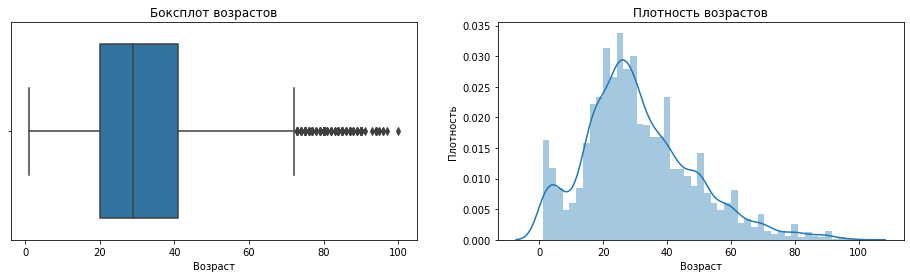

In [9]:
_, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(labels_df['real_age'], ax=axes[0]).set_title('Боксплот возрастов')
sns.distplot(labels_df['real_age'], ax=axes[1]).set_title('Плотность возрастов')
axes[0].set(xlabel='Возраст')
axes[1].set(xlabel='Возраст', ylabel='Плотность');

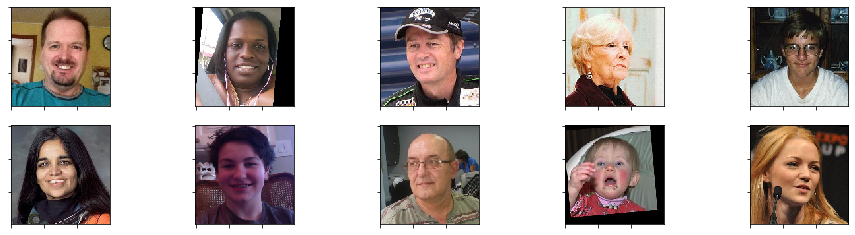

In [10]:
photo_batch = next(datagen_flow)
photos = photo_batch[0][:10]
_, axes = plt.subplots(2, 5, figsize=(16, 4))
for image, ax in zip(photos, axes.ravel()):
    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

# Выводы:
1. Распределение по возрасту почти нормальное. Есть выбросы в виде людей старше 70 лет. 
2. Наиболее плотно выборка распределена в районе от 20 до 40 лет.
3. Обучение модели на предоставленных данных будет ориентировано на более молодых людей. Верхним слоям свёрточной модели, работающим с детальными признаками такая выборка будет недостаточна для выявления конкретных признаков старения и юношества. Вероятно, такая модель не сможет различать людей из возрастных групп старше 40-50 лет и в районе от 10 до 17.  
4. Датасет требует нормализации, т.к. присутствуют как смещённые в сторону фотографии, так и повёрнутые. Оставив датасет без нормализации рискуем как потерять часть данных (например, фото перевёрнутого на 180 градусов человека) либо внести значительные искажения в модель.

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

def load_train(path):
    p = path if path[-1] == '/' else path + '/' # Добавляет '/' в конец path, если нет
    dataframe = pd.read_csv(p + 'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe,
        directory=p + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    p = path if path[-1] == '/' else path + '/'
    dataframe = pd.read_csv(p + 'labels.csv')
    valid_datagen_flow = datagen.flow_from_dataframe(
        dataframe,
        directory=p + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return valid_datagen_flow


def create_model(input_shape):
    
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False)

    model = Sequential()
    model.add(backbone)
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']) 

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=9,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```


Train for 356 steps, validate for 119 steps
Epoch 1/9
356/356 - 44s - loss: 199.0967 - mae: 10.6864 - val_loss: 491.0623 - val_mae: 17.0826
Epoch 2/9
356/356 - 37s - loss: 121.5344 - mae: 8.4300 - val_loss: 249.8142 - val_mae: 11.7890
Epoch 3/9
356/356 - 37s - loss: 89.6196 - mae: 7.2683 - val_loss: 252.8968 - val_mae: 12.0472
Epoch 4/9
356/356 - 36s - loss: 62.3166 - mae: 6.0654 - val_loss: 103.7583 - val_mae: 7.6290
Epoch 5/9
356/356 - 37s - loss: 40.5381 - mae: 4.9798 - val_loss: 145.8097 - val_mae: 9.2671
Epoch 6/9
356/356 - 37s - loss: 30.6106 - mae: 4.2777 - val_loss: 115.4598 - val_mae: 8.4766
Epoch 7/9
356/356 - 36s - loss: 23.8862 - mae: 3.7882 - val_loss: 88.0360 - val_mae: 7.1415
Epoch 8/9
356/356 - 36s - loss: 20.6540 - mae: 3.5170 - val_loss: 85.5293 - val_mae: 7.1113
Epoch 9/9
356/356 - 37s - loss: 16.7898 - mae: 3.1683 - val_loss: 92.7116 - val_mae: 7.3004
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 92.7116 - mae: 7.3004
Test MAE: 7.3004



```

## Анализ обученной модели

1. Каждая эпоха обучения вносит значительный вклад в минимизацию функции потерь. MSE почти кратно падает каждую итерацию. Параллельно MSE каждую эпоху падает и MAE до определённой эпохи. 
2. Начиная с 9 эпохи наблюдаются зачатки переобучения модели из-за непрерывающегося тренда MSE/MAE на обучающих сете и более высоких показателей MSE/MAE на тестовом сете по сравнению с предыдущей эпохой. 
3. Текущая модель выдаёт наилучшие результаты на 8 эпохах, где значение MAE ~ 7. Это означает, что модель в прогнозе возраста в среднем ошибается на 7 лет. Несмотря на отсутствие нормализации модель выдаёт неплохой результат, т.к. 7 лет это такая разница, которую даже человек с трудом может определить для людей старше определённого возраста.
4. Есть предположение, что такое низкое значение ошибки MAE может быть связано с несколькими факторами:
    1. ResNet50 обученный на ImageNet обладает знаниями по возрастным признакам. Напомним, что в нашем датасете в основном преобладают люди молодого возраста от 20 до 40 лет и что любой модели будет недостаточно данных по возрастным людям и юношескому возрасту, чтобы запомнить признаки старения в свёрточной основе. 
    2. В тестовом датасете несоблюдён баланс возраста и молодых людей гораздо больше. 